In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive')

def load_audio_file(file_path, sr=22050):
    print("load_audio_file...")
    audio, sr = librosa.load(file_path, sr=sr, mono=True)
    return audio, sr

def audio_to_spectrogram(audio, n_fft=256, hop_length=128):
    print("audio_to_spectrogram")
    chunk_samples = int((n_fft/2 - 1)*hop_length + n_fft)
    num_chunks = int(np.ceil(len(audio) / chunk_samples))
    print(f"number of chunks: {num_chunks}")
    spectrograms = []
    for i in tqdm(range(num_chunks), desc='Processing audio chunks'):
        start = i*chunk_samples
        end = min((i + 1) * chunk_samples, len(audio))
        chunk = audio[start:end]
        if len(chunk) <= 100: #1초보다 짧으면..
            continue
        elif len(chunk) < chunk_samples:
            chunk = np.pad(chunk, (0, chunk_samples - len(chunk)), 'constant')  # 부족한 부분을 0으로 패딩'''
        # 스펙트로그램 계산
        audio_tf = tf.convert_to_tensor(chunk, dtype=tf.float32)
        S = tf.signal.stft(audio_tf, frame_length=n_fft, frame_step=hop_length)
        #print(f"dataSize{S.shape}")
        S_cropped = S[:128, :128]
        S_abs = tf.abs(S_cropped)
        if S_abs.numpy().size > 0:  # 비어 있지 않은 데이터만 처리
            S_db = librosa.amplitude_to_db(S_abs.numpy())
            spectrograms.append(S_db.T)
    print(".")
    return spectrograms

def save_spectrograms(spectrograms, output_dir, base_filename):
    # 지정된 디렉토리가 없을 경우 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created directory: {output_dir}")

    for i, spec in enumerate(spectrograms):
        np.save(os.path.join(output_dir, f"{base_filename}_chunk_{i}.npy"), spec)

def process_audio_files(folder_path, output_dir, start=0, end=10000):
    all_files = [os.path.join(root, file)
                 for root, dirs, files in os.walk(folder_path)
                 for file in files if file.endswith('.mp3') or file.endswith('.flac')]
    total_files = len(all_files)
    print(f"Total files to process: {total_files}")

    for index, file_path in enumerate(all_files):
        if index >= end: break
        if index < start: continue
        print(f"Processing file {index + 1} of {total_files}: {file_path}")
        base_filename = os.path.splitext(os.path.basename(file_path))[0]
        audio, sr = load_audio_file(file_path)
        spectrograms = audio_to_spectrogram(audio)
        save_spectrograms(spectrograms, output_dir, base_filename)

# 사용 예
input_folder = '/content/drive/My Drive/GANProject/GANpiano'
output_folder = '/content/spec_128_'
process_audio_files(input_folder, output_folder)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total files to process: 1
Processing file 1 of 1: /content/drive/My Drive/GANProject/GANpiano/The Best Of Chopin.mp3
load_audio_file...
audio_to_spectrogram
number of chunks: 57287


Processing audio chunks: 100%|██████████| 57287/57287 [06:53<00:00, 138.40it/s]


.
Created directory: /content/spec_128_


In [ ]:
from numba import cuda
device = cuda.get_current_device()
device.reset()

In [ ]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Layer, Input, Conv2D, Conv2DTranspose, Flatten, Dense, LeakyReLU, BatchNormalization, ReLU, Dropout, Activation, Reshape, ZeroPadding2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

print("GPU Available: ", tf.test.is_gpu_available())
print("Devices:", tf.config.list_physical_devices())

np.set_printoptions(linewidth=200)


GPU Available:  True
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import os
import shutil
from tqdm import tqdm
import signal
from contextlib import contextmanager
import time

# Setting up a timeout handler using signals
class TimeoutException(Exception):
    pass

@contextmanager
def time_limit(seconds):
    def signal_handler(signum, frame):
        raise TimeoutException("Timed out!")
    signal.signal(signal.SIGALRM, signal_handler)
    signal.alarm(seconds)
    try:
        yield
    finally:
        signal.alarm(0)

# Function to copy a file with a timeout
def copy_file_with_timeout(src, dst, timeout=10):
    try:
        with time_limit(timeout):
            shutil.copy(src, dst)
        return True
    except TimeoutException as e:
        print(f"Timeout occurred for {os.path.basename(src)}: {e}")
        return False

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set the source and destination paths
source_path = '/content/drive/My Drive/GANProject/spec_128'
destination_path = '/content/GANProject/spec128'

# Ensure the destination directory exists
os.makedirs(destination_path, exist_ok=True)

# List all npy files and copy them with a timeout and retry if needed
files = [f for f in os.listdir(source_path) if f.endswith('.npy')]
index = 1
for file in tqdm(files, desc="Copying files"):
    if index % 1000 == 0:
        drive.mount('/content/drive', force_remount= True)
    src_file = os.path.join(source_path, file)
    dest_file = os.path.join(destination_path, file)
    index+=1
    if not os.path.exists(dest_file):  # 이미 파일이 존재하지 않는 경우에만 복사
      success = copy_file_with_timeout(src_file, dest_file, timeout=30)  # Set timeout to 30 seconds


      if not success:
          drive.mount('/content/drive', force_remount= True)
          print(f"Retrying {file}...")
          time.sleep(5)  # Wait for 5 seconds before retrying
          copy_file_with_timeout(src_file, dest_file, timeout=30)  # Corrected function call for retry


print("Copy complete")

In [ ]:
def load_spectrogram(file_path):
    # EagerTensor에서 바로 numpy 배열로 변환 후 decode
    file_path = file_path.numpy().decode()
    spec = np.load(file_path)
    spec = np.expand_dims(spec, axis=-1)  # 채널 차원 추가
    factor = np.max(spec) - np.min(spec)
    if factor > 0:
        spec = 2 * (spec - np.min(spec)) / factor - 1  # -1과 1 사이로 정규화
    return spec

def preprocess(file_path):
    # TensorFlow ops에서 사용할 수 있도록 load_spectrogram을 wrapper 함수로 호출
    spectrogram = tf.py_function(load_spectrogram, [file_path], Tout=[tf.float32])
    spectrogram = spectrogram[0]
    return spectrogram

def create_dataset(data_dir, batch_size=32):
    # 파일 경로 로드
    file_paths = [os.path.join(data_dir, fname) for fname in os.listdir(data_dir) if fname.endswith('.npy')]
    print("file_paths")
    # TensorFlow Dataset 객체 생성
    dataset = tf.data.Dataset.from_tensor_slices(file_paths)
    print("tensor_slice")
    # 파일 경로를 실제 데이터로 변환
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    print("dataset.map")
    # 배치 처리 및 prefetching
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    print("dataset.batch")
    # 데이터셋의 배치 형태를 확인하기 위한 코드
    return dataset

In [ ]:
def build_generator(noise_shape):
    #input size: 100
    inputs = Input(shape=noise_shape)

    x = Dense(16*16*256)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Reshape((16, 16, 256))(x)
    #16*16*256
    # Upsampling
    x = Conv2DTranspose(128, kernel_size=5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #32*32*128
    x = Conv2DTranspose(64, kernel_size=5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #64*64*64
    x = Conv2DTranspose(1, kernel_size=5, strides=2, padding='same')(x)
    #128*128*1
    x = Activation('tanh')(x)

    return Model(inputs, x)

def build_discriminator(input_shape):
    #input size: 128*128
    inputs = Input(shape=input_shape)

    x = Conv2D(64, kernel_size=5, strides=2, padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.8)(x)
    #64*64*64
    x = Conv2D(128, kernel_size=5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.8)(x)
    x = RandomShuffleLayer()(x)
    #32*32*128
    '''
    x = Conv2D(256, kernel_size=5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = RandomShuffleLayer()(x)
    '''
    x= Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)

    return Model(inputs, x)


class RandomShuffleLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(RandomShuffleLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Assuming inputs are of shape [batch_size, height, width, channels]
        def shuffle_along_axis(image):
            # Shuffle along the width (axis=1)
            shuffled = tf.random.shuffle(tf.transpose(image, [1, 0, 2]))
            return tf.transpose(shuffled, [1, 0, 2])

        # Apply to each image in the batch
        outputs = tf.map_fn(shuffle_along_axis, inputs, dtype=tf.float32)
        return outputs


Instructions for updating:
Use fn_output_signature instead


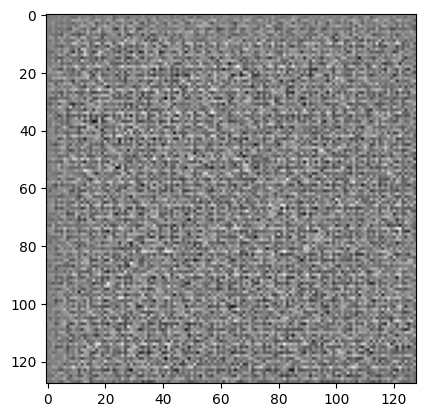

In [ ]:
generator = build_generator((100,))
discriminator = build_discriminator((128,128,1))

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')


In [ ]:
def save_spectrogram(spectrogram, epoch, output_dir, X_mean=-5, X_std=45):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Convert EagerTensor to numpy if not already
    if isinstance(spectrogram, tf.Tensor):
        spectrogram = spectrogram.numpy()

    # Squeeze to remove single-dimensional entries from the shape
    spectrogram = spectrogram.squeeze()

    # Reversing the normalization formula to get the original log magnitude
    X_mag = (spectrogram * X_std) + X_mean
    np.save(os.path.join(output_dir, f'spectrogram_epoch_{epoch}.npy'), X_mag)

    # Configure the plot
    plt.figure(figsize=(10, 4))
    plt.imshow(X_mag, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram at Epoch {epoch}')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.tight_layout()

    # Save the figure
    plt.savefig(os.path.join(output_dir, f'spectrogram_epoch_{epoch}.png'))
    plt.close()


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:

@tf.function

def train_step(images, generator, discriminator, noise_shape):
    noise = tf.random.normal([tf.shape(images)[0]]+ noise_shape)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        # Calculate probabilities for real and fake
        real_prob = tf.math.reduce_mean(real_output)
        fake_prob = tf.math.reduce_mean(fake_output)

        #tf.print("real_output: ", real_prob, summarize=-1)
        #tf.print("fake_output: ", fake_prob, summarize=-1)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

    generator.optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator.optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return disc_loss, gen_loss, real_prob, fake_prob

import traceback

def train_gan(generator, discriminator, dataset, epochs, batch_size, noise_shape, save_interval, output_dir, start_epoch):
    noise_shape = list(noise_shape)
    print("train_gan started")
    loss_log_path = os.path.join(output_dir, "training_log.txt")
        # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    valid = np.ones((batch_size, 1)) * 0.9 # Label Smoothing 적용
    fake = np.zeros((batch_size, 1))

    with open(loss_log_path, "w") as file:
        file.write("Start of training\n")

    try:
        for epoch in range(start_epoch, epochs):
            print(f"Epoch {epoch+1} started")
            for batch_index, data in enumerate(dataset):
                imgs = data[0] if isinstance(data, tuple) else data
                if tf.shape(imgs)[0] != batch_size:
                    continue  # Skip incomplete batches
                d_loss, g_loss, real_prob, fake_prob = train_step(imgs, generator, discriminator, combined, noise_shape)
                print(".", end="")
                if (batch_index + 1) % 80 == 0:
                    print("")
                    log_message = f"Epoch {epoch + 1}, Batch {batch_index + 1}\nD loss: {d_loss.numpy()}, \nG loss: {g_loss.numpy()}\nReal prob: {real_prob.numpy()*100:.2f}%, Fake prob: {fake_prob.numpy()*100:.2f}%\n"
                    print(log_message)
                    with open(loss_log_path, "a") as file:
                        file.write(log_message)


            if (epoch + 1) % save_interval == 0:
                generator.save(f'{output_dir}/generator_epoch_{epoch + 1}')
                discriminator.save(f'{output_dir}/discriminator_epoch_{epoch + 1}')
                noise = tf.random.normal([batch_size]+noise_shape)
                generated_spec= generator(noise, training=False)[0]
                save_spectrogram(generated_spec, epoch+1, output_dir)

            with open(loss_log_path, "a") as file:
                file.write(f"Epoch {epoch + 1} completed.\n-------------------------------------------------\n")

        with open(loss_log_path, "a") as file:
            file.write("End of training\n")
    except Exception as e:
        with open(loss_log_path, "a") as file:
            file.write(f"Error occurred: {str(e)}\n")
            file.write(traceback.format_exc())

In [ ]:
# 모델을 불러와서 학습을 실행하는

from tensorflow.keras.models import load_model


# 경로 설정
data_dir = '/content/GANProject/spec512'
output_dir = 'drive/MyDrive/GANProject/GAN_0606'

# 저장된 모델 경로
generator_path = f'{output_dir}/generator_epoch_10'
discriminator_path = f'{output_dir}/discriminator_epoch_10'
# 하이퍼파라미터 설정
epochs = 200
batch_size = 8
save_interval = 5

# 모델 불러오기
generator = load_model(generator_path)
discriminator = load_model(discriminator_path)

noise_shape = (100,)
input_shape = (128, 128, 1)


"""
# Combined model 재구성
combined_input = Input(shape=noise_shape)
combined_output = discriminator(generator(combined_input))
combined = Model(combined_input, combined_output)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
"""
# 데이터셋 다시 로드 (필요시)
dataset = create_dataset(data_dir, batch_size)


# 학습 재개
train_gan(generator, discriminator, combined, dataset, epochs, batch_size, noise_shape, save_interval=10, output_dir=output_dir, start_epoch=10)

In [ ]:
# 경로 설정
data_dir = '/content/spec_128_'
output_dir = 'drive/MyDrive/GANProject/GAN_0607'

noise_shape = (100,)
input_shape = (128, 128, 1)

# 하이퍼파라미터 설정
epochs = 200
batch_size = 32
save_interval = 5

# 모델 설정 및 컴파일
generator = build_generator(noise_shape)
generator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
discriminator = build_discriminator(input_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.00001, 0.5), metrics=['accuracy'])

"""
# Combined model 설정
discriminator.trainable = True
combined_input = Input(shape=noise_shape)
combined_output = discriminator(generator(combined_input))
combined = Model(inputs=combined_input, outputs=combined_output)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
"""

# 데이터셋 생성 및 훈련 시작
dataset = create_dataset(data_dir, batch_size)

train_gan(generator, discriminator, dataset, epochs, batch_size, noise_shape, save_interval, output_dir, start_epoch=0)
print("GAN Main ends")

file_paths
tensor_slice
dataset.map
dataset.batch
train_gan started
Epoch 1 started
................................................................................
Epoch 1, Batch 80
D loss: 0.1618313491344452, 
G loss: 3.041032075881958
Real prob: 93.55%, Fake prob: 8.52%

................................................................................
Epoch 1, Batch 160
D loss: 0.10084086656570435, 
G loss: 4.0197038650512695
Real prob: 95.81%, Fake prob: 4.86%

................................................................................
Epoch 1, Batch 240
D loss: 0.04622552543878555, 
G loss: 4.6910834312438965
Real prob: 97.49%, Fake prob: 1.68%

................................................................................
Epoch 1, Batch 320
D loss: 0.02379848062992096, 
G loss: 4.80837869644165
Real prob: 99.27%, Fake prob: 1.60%

................................................................................
Epoch 1, Batch 400
D loss: 0.01764727383852005, 
G loss: 5.72899

KeyboardInterrupt: 